In [7]:
import dadi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import pylab

In [2]:
# Parse the VCF file to generate a data dictionary
datafile = '/home/daron/bioInf/wilding/vcf_store/anopheles-rose.3.unifiedGenotyper.cov14x.passQC.merge.pol.vcf.gz'
dd = dadi.Misc.make_data_dict_vcf(datafile, '/home/daron/bioInf/wilding/popstructure/popdifferenciation/dadi/test_panmixia/wilding.popfile.txt')


In [3]:
pop_ids, ns = ['LPdom', 'LPfor'], [40,40]
fs_lp_dom_for = dadi.Spectrum.from_data_dict(dd, pop_ids, ns)


## Test panmixia from LPdom and LPfor

TypeError: unhashable type: 'MaskedConstant'

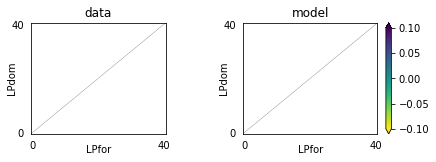

In [8]:
# Extract the joint spectrum asf
pop_ids, ns = ['LPdom', 'LPfor'], [40,40]
fs_lp_dom_for = dadi.Spectrum.from_data_dict(dd, pop_ids, ns)
fs_lp_dom_for_scram = fs_lp_dom_for.scramble_pop_ids()

cmp_fig = pylab.figure(1)
cmp_fig.clear()
dadi.Plotting.plot_2d_comp_multinom(fs_lp_dom_for_scram, fs_lp_dom_for, vmin=0.1, resid_range=3,pop_ids = ('LPdom','LPfor'))
cmp_fig.savefig('/home/daron/bioInf/wilding/popstructure/popdifferenciation/dadi/test_panmixia/LPdom_LPfor.model-data.comparison.pdf')  


In [5]:
### calculate chi2 in observed data

chi2Obs = np.sum((fs_lp_dom_for - fs_lp_dom_for_scram)**2/np.sqrt((fs_lp_dom_for+fs_lp_dom_for_scram/2)))#
chi2Obs

nan

In [6]:
### calculate chi2 in permuted bootstrap
null_chi2 = []
for i in range(0,1000):
    permutedInFile = "/home/daron/bioInf/wilding/popstructure/popdifferenciation/dadi/test_panmixia/dadi_permuted/anopheles-rose.3.unifiedGenotyper.cov14x.passQC.merge.pol.LPdom_LPfor.fs.permuted_"+str(i)
    fs_permuted = dadi.Spectrum.from_file(permutedInFile)
    fs_permuted_scram = fs_permuted.scramble_pop_ids()
    chi2 = np.nansum((fs_permuted - fs_permuted_scram)**2/np.sqrt((fs_permuted+fs_permuted_scram/2)))
    null_chi2.append(chi2)


In [11]:
print(len(null_chi2))

with open('/home/daron/bioInf/wilding/popstructure/popdifferenciation/dadi/test_panmixia/LPdom_LPfor.nullDistri.txt', 'w') as f:
    for item in null_chi2:
        f.write("%s\n" % item)


1000


In [7]:
### calculate pvalue

# add chi2obs to chi2 null distri to make sure the value will be within the distri
null_chi2_dist = null_chi2
null_chi2_dist = np.append(null_chi2_dist, chi2Obs) 

nbins = 25
#n, bins, _ = plt.hist(null_chi2, nbins)
n, bins = np.histogram(null_chi2_dist, nbins)


# get the width of each bin
binChi2ObsIdx = np.where(bins == bins[bins>=chi2Obs][0])[0]

# get the width of each bin
bin_width = bins[1] - bins[0]

# sum over number in each bin and mult by bin width, which can be factored out
integral_given_area = bin_width * sum(n[int(binChi2ObsIdx):len(n)])
integral_total = bin_width * sum(n[0:len(n)])
pvalue = integral_given_area/integral_total
pvalue

0.4465534465534466

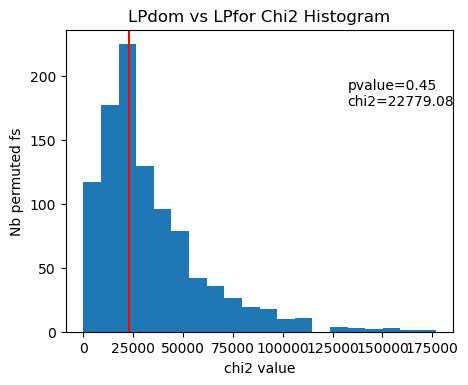

In [8]:
# hist of null distribution
plt.rcParams.update({'figure.figsize':(5,4), 'figure.dpi':100})
n, bins, _ = plt.hist(null_chi2, bins=20)
bin_width = bins[1] - bins[0]
plt.axvline(x=chi2Obs, color="red")
x = np.amax(bins)-(bin_width*5)
y = np.unique(np.sort(n))[len(np.unique(n))-2]
text = "pvalue="+str(round(pvalue, 2))+"\n"+"chi2="+str(round(chi2Obs, 2))
plt.text(x,y,text)
plt.gca().set(title='LPdom vs LPfor Chi2 Histogram', ylabel='Nb permuted fs', xlabel='chi2 value')
plt.savefig('/home/daron/bioInf/wilding/popstructure/popdifferenciation/dadi/test_panmixia/LPdom_LPfor.chi2Distri.pdf')  


In [ ]:
### get limits of residus distribution
from scipy.optimize import curve_fit

resid = dadi.Inference.Anscombe_Poisson_residual(fs_lp_dom_for_scram, fs_lp_dom_for, mask=0.1)
flatresid = np.compress(np.logical_not(resid.mask.ravel()), resid.ravel())

ax = pylab.subplot(2,2,4)
hist,bins,_ = plt.hist(flatresid, bins=50, density=True)

# Get centers of histogram bins
bin_centers = np.mean([bins[:-1],bins[1:]], axis=0)

# Define the Gaussian function
def gaussian(x, mu, sigma, amp):
    return amp*np.exp( -(x - mu)**2 / (2.*sigma**2))

print(hist)

# Curve fit
p_opt,_ = curve_fit(gaussian, bin_centers, hist)

# Get the fit parameters
mu, sigma, amp = p_opt

# pvalue = 0.68: (mu-sigma)
# pvalue = 0.95: (mu-(2*sigma))
# pvalue = 0.99: (mu-(3*sigma))
limits = (mu-(3*sigma))

fit = gaussian(bin_centers, mu, sigma, amp)
plt.plot(bin_centers, hist)
plt.plot(bin_centers, fit)
plt.axvline(x=limits, c="black")
plt.axvline(x=limits*-1, c="black")



In [ ]:
print(resid.shape)
print(limits)

m = np.array(resid)

mask = (m < limits) | (m > limits*-1)
print(mask.shape)
df = pd.DataFrame(mask).reset_index().melt('index')
# index = row , variable = col
df = df.rename(columns={'index': 'LPfor', 'variable': 'LPdom'})
df

txt_fn = "/home/daron/bioInf/wilding/popstructure/popdifferenciation/dadi/test_panmixia/LPdom_LPfor.residuMatrix.melt.tab"
df.to_csv(txt_fn, sep='\t', index=False,  float_format='%.8f')


## Test panmixia from LBVdom and LPdom

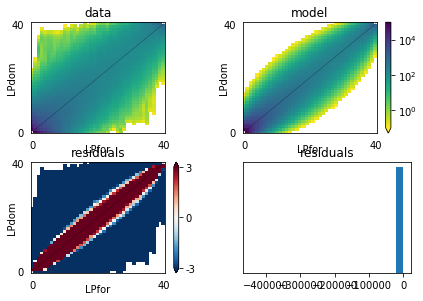

In [5]:
pop_ids, ns = ['LBVdom', 'LPdom'], [40,40]
fs_lbv_lpdom = dadi.Spectrum.from_data_dict(dd, pop_ids, ns)
fs_lbv_lpdom_scram = fs_lbv_lpdom.scramble_pop_ids()

cmp_fig = pylab.figure(1)
cmp_fig.clear()
dadi.Plotting.plot_2d_comp_multinom(fs_lbv_lpdom_scram, fs_lbv_lpdom, vmin=0.1, resid_range=3,pop_ids = ('LBVwil','LPdom'))
cmp_fig.savefig('/home/daron/bioInf/wilding/popstructure/popdifferenciation/dadi/test_panmixia/LBVwil_LPdom.model-data.comparison.pdf')  


In [13]:
chi2Obs = np.sum((fs_lbv_lpdom - fs_lbv_lpdom.scram)**2/np.sqrt((fs_lbv_lpdom+fs_lbv_lpdom.scram/2)))
chi2Obs

18457850.560944583

In [14]:
# calculate chi2 in permuted bootstrap
null_chi2 = []
for i in range(0,1000):
    permutedInFile = "/home/daron/bioInf/wilding/popstructure/popdifferenciation/dadi/test_panmixia/dadi_permuted/anopheles-rose.3.unifiedGenotyper.cov14x.passQC.merge.pol.LBVdom_LPdom.fs.permuted_"+str(i)
    fs_permuted = dadi.Spectrum.from_file(permutedInFile)
    fs_permuted.scram = fs_permuted.scramble_pop_ids()
    chi2 = np.nansum((fs_permuted - fs_permuted.scram)**2/np.sqrt((fs_permuted+fs_permuted.scram/2)))
    null_chi2.append(chi2)


In [15]:
print(len(null_chi2))

with open('/home/daron/bioInf/wilding/popstructure/popdifferenciation/dadi/test_panmixia/LBVwil_LPdom.nullDistri.txt', 'w') as f:
    for item in null_chi2:
        f.write("%s\n" % item)


1000


In [17]:
### calculate pvalue

# add chi2obs to chi2 null distri to make sure the value will be within the distri
null_chi2_dist = null_chi2
null_chi2_dist = np.append(null_chi2_dist, chi2Obs) 

nbins = 25
#n, bins, _ = plt.hist(null_chi2, nbins)
n, bins = np.histogram(null_chi2_dist, nbins)


# get the width of each bin
binChi2ObsIdx = np.where(bins == bins[bins>=chi2Obs][0])[0]

# get the width of each bin
bin_width = bins[1] - bins[0]

# sum over number in each bin and mult by bin width, which can be factored out
integral_given_area = bin_width * sum(n[int(binChi2ObsIdx):len(n)])
integral_total = bin_width * sum(n[0:len(n)])
pvalue = integral_given_area/integral_total
pvalue

0.0

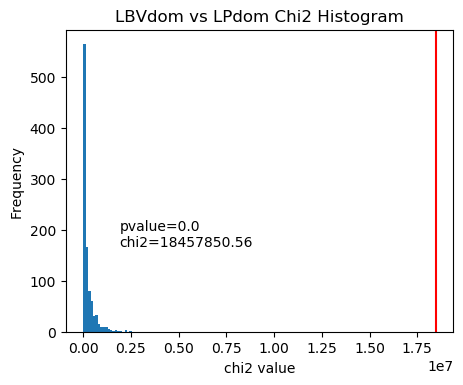

In [21]:
# hist of null distribution
plt.rcParams.update({'figure.figsize':(5,4), 'figure.dpi':100})
n, bins, _ = plt.hist(null_chi2, bins=20)
bin_width = bins[1] - bins[0]
plt.axvline(x=chi2Obs, color="red")
x = np.amax(bins)-(bin_width*5)
y = np.unique(np.sort(n))[len(np.unique(n))-2]
text = "pvalue="+str(round(pvalue, 2))+"\n"+"chi2="+str(round(chi2Obs, 2))
plt.text(x,y,text)
plt.gca().set(title='LBVdom vs LPdom Chi2 Histogram', ylabel='Frequency', xlabel='chi2 value')

plt.savefig('/home/daron/bioInf/wilding/popstructure/popdifferenciation/dadi/LBVwil_LPdom.chi2Distri.pdf')  


## Test panmixia from LBVdom and LPfor

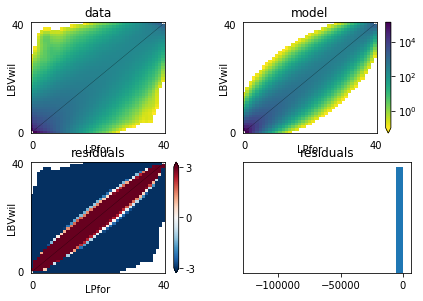

In [4]:
pop_ids, ns = ['LBVdom', 'LPfor'], [40,40]
fs_lbv_lpfor = dadi.Spectrum.from_data_dict(dd, pop_ids, ns)
fs_lbv_lpfor_scram = fs_lbv_lpfor.scramble_pop_ids()

#dadi.Plotting.plot_2d_comp_multinom(fs_lbv_lpdom.scram, fs_lbv_lpdom, vmin=0.1, resid_range=3,pop_ids = ('LBVdom','LPdom'))

cmp_fig = pylab.figure(1)
cmp_fig.clear()
dadi.Plotting.plot_2d_comp_multinom(fs_lbv_lpfor_scram, fs_lbv_lpfor, vmin=0.1, resid_range=3,pop_ids = ('LBVwil','LPfor'))
cmp_fig.savefig('/home/daron/bioInf/wilding/popstructure/popdifferenciation/dadi/test_panmixia/LBVwil_LPfpr.model-data.comparison.pdf')  


In [19]:
chi2Obs = np.sum((fs_lbv_lpdom - fs_lbv_lpdom.scram)**2/np.sqrt((fs_lbv_lpdom+fs_lbv_lpdom.scram/2)))
chi2Obs

30468962.87874197

In [23]:
# calculate chi2 in permuted bootstrap
null_chi2 = []
for i in range(0,1000):
    permutedInFile = "/home/daron/bioInf/wilding/popstructure/popdifferenciation/dadi/test_panmixia/dadi_permuted/anopheles-rose.3.unifiedGenotyper.cov14x.passQC.merge.pol.LBVdom_LPdom.fs.permuted_"+str(i)
    fs_permuted = dadi.Spectrum.from_file(permutedInFile)
    fs_permuted.scram = fs_permuted.scramble_pop_ids()
    chi2 = np.nansum((fs_permuted - fs_permuted.scram)**2/np.sqrt((fs_permuted+fs_permuted.scram/2)))
    null_chi2.append(chi2)


In [24]:
print(len(null_chi2))

with open('/home/daron/bioInf/wilding/popstructure/popdifferenciation/dadi/test_panmixia/LBVwil_LPfor.nullDistri.txt', 'w') as f:
    for item in null_chi2:
        f.write("%s\n" % item)


1000


In [51]:
### calculate pvalue

# add chi2obs to chi2 null distri to make sure the value will be within the distri
null_chi2_dist = null_chi2
null_chi2_dist = numpy.append(null_chi2_dist, chi2Obs) 

nbins = 25
#n, bins, _ = plt.hist(null_chi2, nbins)
n, bins = np.histogram(null_chi2_dist, nbins)


# get the width of each bin
binChi2ObsIdx = np.where(bins == bins[bins>=chi2Obs][0])[0]

# get the width of each bin
bin_width = bins[1] - bins[0]

# sum over number in each bin and mult by bin width, which can be factored out
integral_given_area = bin_width * sum(n[int(binChi2ObsIdx):len(n)])
integral_total = bin_width * sum(n[0:len(n)])
pvalue = integral_given_area/integral_total
pvalue

0.0

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'chi2 value'),
 Text(0.5, 1.0, 'LBVdom vs LPfor Chi2 Histogram')]

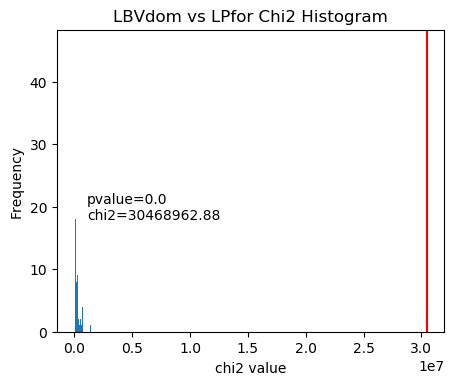

In [52]:
# hist of null distribution
plt.rcParams.update({'figure.figsize':(5,4), 'figure.dpi':100})
n, bins, _ = plt.hist(null_chi2, bins=20)
bin_width = bins[1] - bins[0]
plt.axvline(x=chi2Obs, color="red")
x = np.amax(bins)-(bin_width*5)
y = np.unique(np.sort(n))[len(np.unique(n))-2]
text = "pvalue="+str(round(pvalue, 2))+"\n"+"chi2="+str(round(chi2Obs, 2))
plt.text(x,y,text)
plt.gca().set(title='LBVdom vs LPfor Chi2 Histogram', ylabel='Frequency', xlabel='chi2 value')